<h1 style="font-size:300%;">AI4EduRes'2023: <br />Fine-Tuning RoBERTa for Downstream Tasks</h1>
<p>This notebook details how to use RoBERTa with Pytorch and minimal use of HuggingFace features. Additionally, this notebook illustrates RoBERTa without dynamic padding of inputs.</p>

# 📽️ IMDb Review Sentiment Classification

## Platform Check
Ensure we're on an ARM environment. 

NOTE:  If you are not on an ARM environment, update `params.device` to `torch.device('cuda' if torch.cuda.is_available() else 'cpu')`

In [1]:
import platform

if platform.platform() == 'macOS-13.0-arm64-i386-64bit':
    print(f"We're Armed: {platform.platform()}")
else:
    print(f"WARNING! NOT ARMED: {platform.platform()}")

We're Armed: macOS-13.0-arm64-i386-64bit


## Imports & Settings

In [2]:
import params

"""
utils imports the following functions:
    preprocessing, preprocessing_trunkless, preprocessing_dyna
    collate, print_sentence_encoding
"""
from utils import *
from trainer import *

import pandas as pd

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import RobertaForSequenceClassification

# suppress model warning
from transformers import logging
logging.set_verbosity_error()

# set logging level
import logging
logging.basicConfig(format='%(message)s', level=logging.INFO)

In [3]:
# Adjust parameters if necessary
params.num_labels = 2
params.output_dir = "imdb_512"

## Load Data

### IMDb

For this notebook, I've prepared a train/validate/test split of the IMDb movie review dataset. I've also mapped the string sentiment labels to binary integers and renamed the columns to "text" and "label".

In [4]:
train_dataset_path = 'data/inter_IMDB_sentiment/IMDB_train.csv'
validate_dataset_path = 'data/inter_IMDB_sentiment/IMDB_validate.csv'

train_df = pd.read_csv(train_dataset_path)
validate_df = pd.read_csv(validate_dataset_path)

train_df.head()

,text,label
0,"Beautifully photographed and ably acted, gener...",0
1,"Well, where to start describing this celluloid...",0
2,I first caught the movie on its first run on H...,1
3,I love Umberto Lenzi's cop movies -- ROME ARME...,0
4,I generally won't review movies I haven't seen...,0


In [5]:
# view training dataset
print("train_df Info:")
print(train_df.info())
print("\ntrain_df Value Counts")
print(train_df['label'].value_counts())

train_df Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    36000 non-null  object
 1   label   36000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 562.6+ KB
None

train_df Value Counts
1    18056
0    17944
Name: label, dtype: int64


In [6]:
# view validation dataset
print("validate_df Info:")
print(validate_df.info())
print("\n validate_df Value Counts")
print(validate_df['label'].value_counts())

validate_df Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4000 non-null   object
 1   label   4000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 62.6+ KB
None

 validate_df Value Counts
0    2012
1    1988
Name: label, dtype: int64


## Preprocess
Below, we prepare our input text sequences to be accepted by the model. This involves tokenization and encoding of our sequences.

<ul>

<b>Tokenization</b> :  Splitting strings into word or sub-word token strings <br />
<b>Encoding</b> : Converting those token strings into integers<br />

</ul>

### Understanding Tokenization & Encoding

Below, we briefly explore RoBERTa's tokenization process. RoBERTa uses a type of Byte-Pair Encoding that creates subword units using bytes rather than unicode characters. This allows it to learn a modestly-sized subword vocabulary without introducing any “unknown” tokens. You can learn more about Byte-Pair Encoding here: https://huggingface.co/docs/transformers/tokenizer_summary. <br />


Most text preprocessing, beyond tokenization and encoding, is largely unnecessary for RoBERTa-based models. For example, the removal of stop words, a common text preprocessing technique, is unnecessary as RoBERTa's dictionary not only includes these words, but the training corpus and pre-training process include these words as well. Casing is also accounted for, meaning RoBERTa will process and infer from casing in input text.<br />

We can see examples of sub-word tokenization, distinction between vocabulary words of different casing, special tokens, and how characters such as spaces are represented below.<br />

Our first example shows how the RoBERTa encodes the same word with different casing. Our second example illustrates how it handles non-words, spaces, and attention masks.

In [7]:
# View Encoding of Title-Case "Hello"
sequence_1 = "Hello"
encoding_1 = params.tokenizer.encode_plus(
                        sequence_1,
                        add_special_tokens = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )


token_id_1 = encoding_1['input_ids']
attention_masks_1 = encoding_1['attention_mask']

# View Encoding of Lower-Case "hello"
sequence_2 = "hello"
encoding_2 = params.tokenizer.encode_plus(
                        sequence_2,
                        add_special_tokens = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )


token_id_2 = encoding_2['input_ids']
attention_masks_2 = encoding_2['attention_mask']


print_sentence_encoding(token_id_1, attention_masks_1)
print_sentence_encoding(token_id_2, attention_masks_2)


╒══════════╤═════════════╤══════════════════╕
│ Tokens   │   Token IDs │   Attention Mask │
╞══════════╪═════════════╪══════════════════╡
│ <s>      │           0 │                1 │
├──────────┼─────────────┼──────────────────┤
│ Hello    │       31414 │                1 │
├──────────┼─────────────┼──────────────────┤
│ </s>     │           2 │                1 │
╘══════════╧═════════════╧══════════════════╛
╒══════════╤═════════════╤══════════════════╕
│ Tokens   │   Token IDs │   Attention Mask │
╞══════════╪═════════════╪══════════════════╡
│ <s>      │           0 │                1 │
├──────────┼─────────────┼──────────────────┤
│ hello    │       42891 │                1 │
├──────────┼─────────────┼──────────────────┤
│ </s>     │           2 │                1 │
╘══════════╧═════════════╧══════════════════╛


In [8]:
sequence = "Hello world,   the sldkj ug"
test = params.tokenizer.encode_plus(
                        sequence,
                        add_special_tokens = True,
                        max_length = 20,
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )


token_id = test['input_ids']
attention_masks =test['attention_mask']

print_sentence_encoding(token_id, attention_masks)

╒══════════╤═════════════╤══════════════════╕
│ Tokens   │   Token IDs │   Attention Mask │
╞══════════╪═════════════╪══════════════════╡
│ <s>      │           0 │                1 │
├──────────┼─────────────┼──────────────────┤
│ Hello    │       31414 │                1 │
├──────────┼─────────────┼──────────────────┤
│ Ġworld   │         232 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ,        │           6 │                1 │
├──────────┼─────────────┼──────────────────┤
│ Ġ        │        1437 │                1 │
├──────────┼─────────────┼──────────────────┤
│ Ġ        │        1437 │                1 │
├──────────┼─────────────┼──────────────────┤
│ Ġthe     │           5 │                1 │
├──────────┼─────────────┼──────────────────┤
│ Ġs       │         579 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ld       │        4779 │                1 │
├──────────┼─────────────┼──────────────────┤
│ kj       │       36085 │        

### Tokenizing Training Data

Our preprocessing function, located in `utils.py`,  will tokenize and encode our strings according to RoBERTa's pre-defined tokenization and encoding dictionary. The returned result is a dictionary that includes:

<ul>

<b>token/input ids</b> : A list of integers that represent our tokenized and encoded string<br />
<b>attention masks</b> : A list of 1's and 0's mapped to each token id. 1 represents an id to which the model should apply attention and 0 represents an id to which the model may not apply attention (padding tokens, for example).

</ul>

The dictionary is parsed out to lists which we can then convert to tensors and construct training/validation datasets that are acceptable for our dataloaders later in this notebook. We also note the following:

- Our preprocessing function includes Huggingface's `tokenizer.encode_plus` method, for simplicity.
- The following can be done more succinctly, for example, with our data stored as a `datasets.Dataset` object which enables features such as mapping functions to all splits of our data at once. However, the below loop is a bit more illustrative.

In [9]:
train_token_id = []
train_attention_masks = []

# encode training text
for sample in train_df.text.values:
  encoding_dict = preprocessing(sample, params.tokenizer)
  # parse encoding dict to lists
  train_token_id.append(encoding_dict['input_ids']) 
  train_attention_masks.append(encoding_dict['attention_mask'])

# create tensors for our token ids, attention masks, and labels
train_token_id = torch.cat(train_token_id, dim = 0)
train_attention_masks = torch.cat(train_attention_masks, dim = 0)
train_labels = torch.tensor(train_df.label.values)

In [10]:
# encode validation text 
validate_token_id = []
validate_attention_masks = []

# encode training text
for sample in validate_df.text.values:
  encoding_dict = preprocessing(sample, params.tokenizer)
  # parse encoding dict to lists
  validate_token_id.append(encoding_dict['input_ids']) 
  validate_attention_masks.append(encoding_dict['attention_mask'])

# create tensors for our token ids, attention masks, and labels
validate_token_id = torch.cat(validate_token_id, dim = 0)
validate_attention_masks = torch.cat(validate_attention_masks, dim = 0)
validate_labels = torch.tensor(validate_df.label.values)

Below, we show that our inputs are either:
1. Truncated to `max_length`, 512 tokens
2. Padded to `max_length`, 512 tokens

The result is that every input is of length 512.

In [11]:
# view token_id shape
print("Size: [num_samples, max_input_size]")
print(train_token_id.size(), "\n")

# view and decode a single sequence
print("Length:", len(train_token_id[(13)]))
print(train_token_id[13])
print(params.tokenizer.decode(train_token_id[13]))

Size: [num_samples, max_input_size]
torch.Size([36000, 512]) 

Length: 512
tensor([    0,   863, 11278,     8, 11776,  7815,    32,   233,     9,    41,
         8180, 15893,     9,   559,   822,  6644,     4,    20,  9004,  1956,
          197,  5478,    14,    51,   860,     7, 20489,     5,  3157,    77,
            5,   168,     8,   433,  7313,  7018,  8807,     8,  1719,    62,
            5,  1061,  3817,     5,  1281,   529,    11,  8432,  2457,  3321,
            4,    85,    16,  3668, 17052,     7,   192,   141,   209,  7850,
         1159,    33,    57,  9441,     8,   385, 31756,    30,     5,  9004,
          249,     8,  3828,     7,  1789,    11,   559,  7341,    13,  3981,
         2788,  3731,     8,    25, 13543,    13,   643,  2163,     4,    20,
          129,  9327,   631,    59,    42,  1569,    16,    14,    24,    40,
           45,  1338,     5,  4007, 15444,    11,  6171,    25,    24,    40,
          129,    28,  2343,    24, 11327,     8,    45,    28,   7

In [12]:
# view token_id shape
print("Size: [token_length]")
print("Token @ index 10: ", train_token_id[10].size())
print("Token @ index 30,001: ", train_token_id[30001].size())

Size: [token_length]
Token @ index 10:  torch.Size([512])
Token @ index 30,001:  torch.Size([512])


## Construct Input Datasets
Here we construct the dataset objects containing all of the necessary data for fine-tuning. `torch.utils.data.Dataset` allows us to use pre-loaded datasets as well as our own data. Datasets store the samples and their corresponding labels.

In [13]:
# Train and validation sets
train_set = TensorDataset(train_token_id, 
                          train_attention_masks, 
                          train_labels)

val_set = TensorDataset(validate_token_id, 
                        validate_attention_masks, 
                        validate_labels)

We then give our dataset objects to dataloaders. `torch.utils.data.DataLoader` wraps an iterable around the Dataset to enable easy access to the samples.

<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html"> View the Pytorch Datasets & Dataloaders Documentation</a>

In [14]:
# Prepare DataLoaders
train_dataloader = DataLoader(
            train_set,
            batch_size = params.batch_size,
        )

validation_dataloader = DataLoader(
            val_set,
            batch_size = params.batch_size,
        )

In [15]:
# view an example from the dataloader
next(iter(train_dataloader))

[tensor([[    0, 29287, 34717,  ...,     1,     1,     1],
         [    0,  8346,     6,  ...,     1,     1,     1],
         [    0,   100,    78,  ...,     1,     1,     1],
         ...,
         [    0,   863, 11278,  ...,     1,     1,     1],
         [    0,   100,  1017,  ...,     1,     1,     1],
         [    0, 35634,  1268,  ...,     1,     1,     1]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1])]

## Train
Before training, we must instantiate our core model. Here, we download transformers.RobertaForSequenceClassification from HuggingFace, which is a RoBERTa model with a linear layer for sentence classification (or regression) on top of the pooled output.

The model we load here may come from any source. Pytorch, for example, also makes pre-trained models available for fine-tuning. Depending on the source, we may or may not have to manually attach our own classification head. We use HuggingFace in this example as it is particularly simple to load a models with new classification heads.

In [16]:
# Load the RobertaForSequenceClassification model
model = RobertaForSequenceClassification.from_pretrained('roberta-base',
                                                         num_labels = params.num_labels,
                                                         output_attentions = False,
                                                         output_hidden_states = False,
                                                         )

# view the model summary by passing dummy data of compatible shape
from torchinfo import summary
summary(model, input_size=(1, 512), dtypes=['torch.IntTensor'])

Layer (type:depth-idx)                                       Output Shape              Param #
RobertaForSequenceClassification                             [1, 2]                    --
├─RobertaModel: 1-1                                          [1, 512, 768]             --
│    └─RobertaEmbeddings: 2-1                                [1, 512, 768]             --
│    │    └─Embedding: 3-1                                   [1, 512, 768]             38,603,520
│    │    └─Embedding: 3-2                                   [1, 512, 768]             768
│    │    └─Embedding: 3-3                                   [1, 512, 768]             394,752
│    │    └─LayerNorm: 3-4                                   [1, 512, 768]             1,536
│    │    └─Dropout: 3-5                                     [1, 512, 768]             --
│    └─RobertaEncoder: 2-2                                   [1, 512, 768]             --
│    │    └─ModuleList: 3-6                                  --               

In [17]:
# set model to device
model.to(params.device)
print(f"Trained Dataset: {train_dataset_path}")
print(f"Device: {params.device}")

# define optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=params.learning_rate) #roberta

# initialize trainer
trainer = Trainer(model=model,
                  device=params.device,
                  tokenizer=params.tokenizer,
                  train_dataloader=train_dataloader,
                  validation_dataloader=validation_dataloader,
                  epochs=params.epochs,
                  optimizer=optimizer,
                  val_loss_fn=params.val_loss_fn,
                  num_labels=params.num_labels,
                  output_dir=params.output_dir,
                  save_freq=params.save_freq,
                  checkpoint_freq=params.checkpoint_freq,)

Trained Dataset: data/inter_IMDB_sentiment/IMDB_train.csv
Device: mps


In [ ]:
# fit the model to our training data - fine-tuning
trainer.fit()

<p style="text-align: left;"><img src="presentation_resources/imdb_512_training.png"  align="left"></p>

## Inference

Once a model is fine-tuned, we can load the model, its tokenizer, pre-process new input, and generate predictions.

### Imports for Inference


In [18]:
from transformers import RobertaTokenizer
from transformers import TextClassificationPipeline
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

### Infer w/Pytorch

Our first example quickly shows how to infer with Pytorch, which involves instantiating the pre-trained model and applying our fine-tuned model's state. We can then put the model into eval mode and run inference.

In [19]:
# Get State Dict Location & Tokenizer Path
pt_check_path = 'models/imdb_512/E02_A0.96_F0.96/checkpoint.pt'
tokenizer_path = 'models/imdb_512/E02_A0.96_F0.96'

# Instantiate core model
# This can be done with Huggingface, from local, from Pytorch, etc
model = RobertaForSequenceClassification.from_pretrained('roberta-base',
                                                         num_labels = params.num_labels,
                                                         output_attentions = False,
                                                         output_hidden_states = False,
                                                         )

# Get Tokenizer
tokenizer = RobertaTokenizer.from_pretrained(tokenizer_path, local_files_only=True)

# load and apply fine-tuned model state to core model
checkpoint = torch.load(pt_check_path)
model.load_state_dict(checkpoint['model_state_dict'])

# set to eval mode
model.eval()

# tokenize inputs
inputs = tokenizer(["I hate this movie!", "I love this movie!"], return_tensors="pt")

# infer
output = model(inputs['input_ids'], inputs['attention_mask'])

In [20]:
# get logits from output
logits = output.logits

# loop through logits
for i, v in enumerate(logits):
    # get index of largest value
    predicted_class_id = v.argmax().item()
    # get & decode input, match with predicted_class_id
    print(params.tokenizer.decode((inputs['input_ids'][i])), predicted_class_id)

<s>I hate this movie!</s> 0
<s>I love this movie!</s> 1


### Infer with HugginFace Pipeline

HuggingFace's pipeline method allows us to streamline the inference process further.

In [21]:
PATH = 'models/imdb_512/E02_A0.96_F0.96'
model = AutoModelForSequenceClassification.from_pretrained(PATH, local_files_only=True)
tokenizer = RobertaTokenizer.from_pretrained(PATH, local_files_only=True)

# define pipeline
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=2, max_length=512, truncation=True)

In [22]:
pipe("i hate this movie")

[[{'label': 'LABEL_0', 'score': 0.9976567029953003},
  {'label': 'LABEL_1', 'score': 0.002343281637877226}]]

### Run Whole Test Set & Evaluate
We will use the HuggingFace pipeline with a loop in order to generate predictions for our entire test set.

### Load Test Data


In [23]:
# Load Test Data
test_df = pd.read_csv('data/inter_IMDB_sentiment/IMDB_test.csv')

# test_df = test_df.sample(n=500, random_state=1)
test_df.head()

,text,label
0,With No Dead Heroes you get stupid lines like ...,0
1,I thought maybe... maybe this could be good. A...,0
2,An elite American military team which of cours...,0
3,Ridiculous horror film about a wealthy man (Jo...,0
4,"Well, if you are one of those Katana's film-nu...",1


In [ ]:
# get sequences
test_input = test_df['text'].to_list()

test_output = []

# pipe sequences to tokenizer -> model
with tqdm(test_input, unit="test") as prog:
    for step, test in enumerate(prog):
        prog.set_description(f"Test {step+1}")
        # append results to test_output list
        test_output.append(pipe(test)[0])

In [30]:
print("Test Output Slice:")
test_output[:5]

Test Output Slice:


[[{'label': 'LABEL_0', 'score': 0.998106837272644},
  {'label': 'LABEL_1', 'score': 0.001893149223178625}],
 [{'label': 'LABEL_0', 'score': 0.9981493949890137},
  {'label': 'LABEL_1', 'score': 0.0018506310880184174}],
 [{'label': 'LABEL_0', 'score': 0.9985480904579163},
  {'label': 'LABEL_1', 'score': 0.00145185727160424}],
 [{'label': 'LABEL_0', 'score': 0.9984475374221802},
  {'label': 'LABEL_1', 'score': 0.0015524596674367785}],
 [{'label': 'LABEL_1', 'score': 0.5626480579376221},
  {'label': 'LABEL_0', 'score': 0.43735191226005554}]]

In [25]:
# parse target predictions to new list
predictions = []

for i in test_output:
    predictions.append(i[0]['label'])
    
print(len(predictions))
print(predictions[:10])

10000
['LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_1', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0']


In [26]:
# remove "LABEL_" and cast as int
for i, v in enumerate(predictions):
    predictions[i] = int(v.replace("LABEL_",""))

print(predictions[:10])

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


In [27]:
# get accuracy and F1
acc = accuracy_score(test_df['label'], predictions)
f1 = f1_score(test_df['label'], predictions)

print("Accuracy: ", acc)
print("F1: ", f1)

Accuracy:  0.955
F1:  0.9545270816491511


# ⏩ How Do We Optimize?
The training process presented in this notebook is quite slow. How can we optimize to speed the process up without much or any impact to accuracy/F1?

<p style="text-align: center;"><img src="presentation_resources/giphy.gif" width="750" align="center"></p>


We have two simple options, both of which involve methods that shorten the input lengths:
1. Decrease `max_length`
2. Dynamic Padding

<ul>

<b>Decrease `max_length`</b> : The maximum number of tokens per sequence that RoBERTa can accept is 512. However, we may consider that the information necessary to classify our sequences accurately is available within far fewer than 512 tokens. We can truncate our input sequences to 256 tokens, for example, which would halve the number of calculations performed by comparison to inputs of 512 tokens.

By exploring the training data a bit more thoroughly, we can support this argument further by noticing that the majority of our inputs will be of sequence length 256 or shorter.

</ul>

In [28]:
# tokenize training sequences and get lengths
unpadded_token_id = []

for sample in train_df.text.values:
  encoding_dict = preprocessing_trunkless(sample, params.tokenizer)
  unpadded_token_id.append(encoding_dict['input_ids']) 

lengths = []
count_256 = 0
count_512 = 0
for i in unpadded_token_id:
    i_length = len(i)

    if i_length <= 256:
      count_256 += 1

    if i_length <= 512:
      count_512 += 1

    lengths.append(i_length)

Total dataset Size: 36000
Num Sequences with Token Lengths <= 256: 21029
Num Sequences with Token Lengths <= 512: 31211


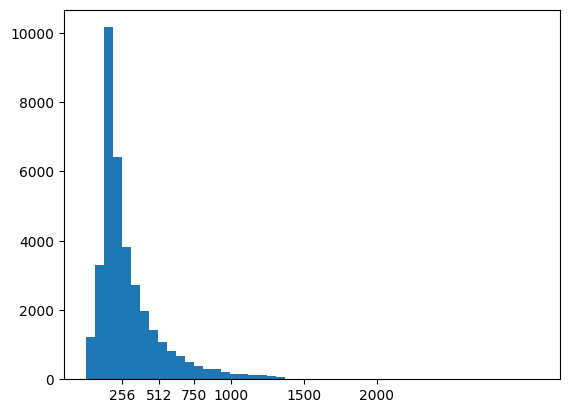

In [29]:
# visualize lengths of training sequences
import matplotlib.pyplot as plt

# setup the plot
fig, ax = plt.subplots()

plt.hist(lengths, bins=50)
# now, define the ticks (i.e. locations where the labels will be plotted)
xticks = [256, 512, 750, 1000, 1500, 2000]

# also define the labels we'll use (note this MUST have the same size as `xticks`!)
xtick_labels = [256, 512, 750, 1000, 1500, 2000]

# add the ticks and labels to the plot
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)

print(f"Total dataset Size: {len(unpadded_token_id)}")
print(f"Num Sequences with Token Lengths <= 256: {count_256}")
print(f"Num Sequences with Token Lengths <= 512: {count_512}")

plt.show() 

<ul>

<b>Dynamic Padding</b> : We may also employ a process called "Dynamic Padding". Because models accept tensors as inputs, and nested tensors on the same dimension must be of the same length, this notebook pads ALL inputs to the `max_length` value so that our inputs may be stored in the input tensor. Alternatively, we may leverage a collation function and our dataloaders to pad sequences and create tensors after each batch is created, but before each batch is handed to the model. This allows us to pad each batch to the length of the longest tensor in the given batch, decreasing input sizes overall.

</ul>

View our last notebook, `03_IMDB_dyna.ipynb`, to see how we can implement shorter `max_length` and dynamic padding on this dataset.